## Генерация датасета (упрощенная версия - баз spacial)

Сложность - в REST-характере работы (без запоминания состояния). Поэтому генерация одним промптом будет давать практически идентичные сцены


Генерируем только объекты и признаки, причем без суперсложных конструкций. Для упрощения процесса генерация происходит в несколько этапов:

- выбор локации из списка (LOCATIONS)
- запрос к LLM на генерацию объектов для локации (исключаем объекты, которые в привязке к данной локации ранее использовались чаще порогового значения
- по каждому объекту запрос на генерацию признаков для данного объекта (заданное число признаков из неравномерного распределения - смещение в нужном нам направлении). Исключаем признаки, которые ранее появлялись слишком часто (общий список)
- упаковываем это в json - это наше хорошее ground-truth описание объектов и призаков из сцены
- генерируем по json описанию текстовое описание сцены. для экономии ресурсов по одной сцене делаем нескольго различных генераций (2-3). В нашей задаче степени свободы - пространственные признаки и порядок объектов и признаков в предложении, так что некоторое разнообразие будет

**Замечание**: если требовалось бы геренировать тройки для spacial описаний, то нужно было бы отдельно делать запрос к LLM на предмет валидации сцены (исключить предложения вида "автомобиль находится в чайнике" и тп) но в задаче генерации объектов и признаков валидация избыточна так как LLM справляются хорошо

In [1]:
import sys
import os
import random
import logging
import json
import copy

from tqdm import tqdm
from dotenv import load_dotenv
from pathlib import Path
from collections import defaultdict, Counter

lib_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(lib_path)

#from library.locations import LOCATIONS
from library.locations import VAL_LOCATIONS

from library.llm_connector import request_llm
from library.graph_vizualization import draw_scene_graph, scene_to_graph

dotenv_path = Path(os.getcwd()).resolve().parent / '.env'
load_dotenv(dotenv_path)

LOG_FILE = "ds_generation.log"
logging.basicConfig(filename=LOG_FILE, level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

API_KEY = os.getenv("API_KEY")
API_KEY_DS = os.getenv("API_KEY_DS")

MAX_OBJECTS = 4
MIN_OBJECTS = 2
MEAN_OBJECTS = 3

MAX_PROPS = 3
MIN_PROPS = 0
MEAN_PROPS = 1

#MAX_DESCR_PER_SCENE = 3 # максимальное количество различных описаний сцен на одно json описание
MAX_DESCR_PER_SCENE = 1

# параметры батчевания
#NUM_BATCHES = 50
#BATCH_SIZE = 100

NUM_BATCHES = 5
BATCH_SIZE = 50

#DATASET_DIR = Path("dataset_validation")

DATASET_DIR = Path("dataset_validation")
DATASET_DIR.mkdir(exist_ok=True)

# параметры разнообразия
PROPERTY_THRESHOLD = 75  # N — порог по признакам
OBJECT_THRESHOLD = 75    # M — порог по объектам

### Генерация объектов

In [2]:
def generate_objects(location, n_objects, exclude_objects_dict):
    
    exclude_objects = exclude_objects_dict.get(location,"")    
    
    prompt = f"""
    Локация: {location}. Назови {n_objects} строго предметов которые могут находиться в этой локации.
    Избегай объекты, состоящие не из одного слова. Избегай объекты, не являющиеся предметами ("музыка", "атмосфера",
    "перекус", "воздух", "разлив" и тд). Нельзя выдавать слова, не являющиеся объектами ("душевое", "зубная" и тд)
    и появление которых в этой локации маловероятно. Если предметов несколько, все они должны быть различными.
    """
    if len(exclude_objects) > 0:
        prompt += f"\nНельзя использовать предметы: {', '.join(exclude_objects)}.\n" 

    
    prompt += f"""
    Ответ выдай в начальной форме слова  (именительный падеж единственного числа). 
    Результат выведи строго в json строго в формате

    {{
        'objects':['объект1', 'объект2']
    }}
    """    
    #print(prompt)
    
    # deepseek-chat дает более адекватную выдачу по сравнению с gpt-4o-mini
    objects = request_llm(
        prompt, API_KEY_DS, temperature=0.7, max_tokens=1000, 
        model='deepseek-chat', platform='deepseek', response_type="json_object")

    #print(objects)    
    return objects

### Генерация объектов: проверка

In [3]:
# объекты, которые исключены из генерации
# будем собирать списки отдельно по локациям, чтобы не смешивать
exclude_objects_dict = {
    "санузел": ["унитаз", "раковина", "душ", "зеркало","стиральная машина","гладильная доска"],
    "комната": ["кровать","шкаф","стул", "стол", "компьютер", "книга", "лампа", "ковер"]
}

In [4]:
# выбираем локацию и количество обхектов
location = "комната"  # random.choice(LOCATIONS)
n_objects = 5        #random.randint(MIN_OBJECTS, MAX_OBJECTS)

print(location, n_objects)

комната 5


In [5]:
# deepseek-chat дает более адекватную выдачу по сравнению с gpt-4o-mini
objects = generate_objects(location, n_objects, exclude_objects_dict)
objects = json.loads(objects)

In [6]:
print(objects)

{'objects': ['зеркало', 'телевизор', 'картина', 'ваза', 'часы']}


## Генерация призанков по данному объекту

In [7]:
def generate_properties(obj, n_props, exclude_properties_list):
    # exclude_properties_list - будем отсекать частые свойства в общем списке
    
    prompt = f"""
    Тебе дан предмет "{obj}". Назови {n_props} его свойств. Это может быть размер, цвет, форма, вес и тд.
    Избегай свойства, состоящие не из одного слова. Избегай свойства, которыев реальном мире редко соответствуют 
    данному объекту или не соответствуют вообще ("стеклянный молоток", "тканевый шкаф" и тд). Свойство не может 
    быть существительным 
    """
    if len(exclude_properties_list) > 0:
        prompt += f"\nНельзя использовать свойства: {', '.join(exclude_properties_list)}.\n" 

    
    prompt += f"""
    Ответ выдай в форме, согласованной с формой в которой дан объект (род, число, падеж) по правилам русского языка. 
    Результат выведи строго в json строго в формате

    {{
        '{obj}':['свойство1', 'свойство2']
    }}
    """    
    #print(prompt)
    
    # deepseek-chat дает более адекватную выдачу по сравнению с gpt-4o-mini
    props = request_llm(
        prompt, API_KEY_DS, temperature=0.7, max_tokens=1000, 
        model='deepseek-chat', platform='deepseek', response_type="json_object")

    #print(props)    
    return props

### Генерация призанков: тестируем

In [8]:
exclude_properties_list = ["синяя","тупая","мягкая", "квадратная", "легкая", "пушистая", "белая"]
props = generate_properties("подушка", 5, exclude_properties_list)
print(props)

{
    "подушка": ["круглая", "тяжелая", "гладкая", "ароматная", "упругая"]
}


## Генерация одной сцены (json)

In [9]:
# для выбора числа прилагательных по заданному существительному.
# у нас в среднем должно получаться не равномерно
def biased_random_chioce(n, m, k):
    values = list(range(n, m + 1))
    weights = [1 / (1 + abs(x - k)) for x in values]
    weights = [w ** 1.3 for w in weights]

    return random.choices(values, weights=weights, k=1)[0]

In [10]:
exclude_properties_list = ["синяя","тупая","мягкая", "квадратная", "легкая", "пушистая", "белая"]
exclude_objects_dict = {
    "санузел": ["унитаз", "раковина", "душ", "зеркало","стиральная машина","гладильная доска"],
    "комната": ["кровать","шкаф","стул", "стол", "компьютер", "книга", "лампа", "ковер"]
}

In [11]:
def generate_scene(exclude_objects_dict = dict(), exclude_properties_list = []):
    # выбираем локацию и количество обхектов
    location = random.choice(VAL_LOCATIONS)
    n_objects = biased_random_chioce(MIN_OBJECTS, MAX_OBJECTS, MEAN_OBJECTS)
    
    result = {'location': location, 'objects':[]}
    #print(result)
    objects = generate_objects(location, n_objects, exclude_objects_dict)
    objects = json.loads(objects)
    #print(objects)
    
    for obj in objects['objects']:
        #print(obj)
        n_props = biased_random_chioce(MIN_PROPS, MAX_PROPS, MEAN_PROPS)
        if n_props > 0:
            props = dict(json.loads(generate_properties(obj, n_props, exclude_properties_list)))
            result['objects'].append(props)
        else:
            result['objects'].append({obj: []})    
            
    return result
   
    

In [12]:
scene = generate_scene()
scene_text = json.dumps(scene, ensure_ascii=False, indent=2)
print(scene_text)

{
  "location": "пекарня",
  "objects": [
    {
      "тесто": [
        "липкое"
      ]
    },
    {
      "печь": [
        "горячая"
      ]
    },
    {
      "мука": [
        "белая"
      ]
    },
    {
      "ножи": [
        "острые"
      ]
    }
  ]
}


## Проверим итоговую генерацию сцены на графе

{'location': 'пекарня', 'objects': [{'тесто': ['липкое']}, {'печь': ['горячая']}, {'мука': ['белая']}, {'ножи': ['острые']}]}


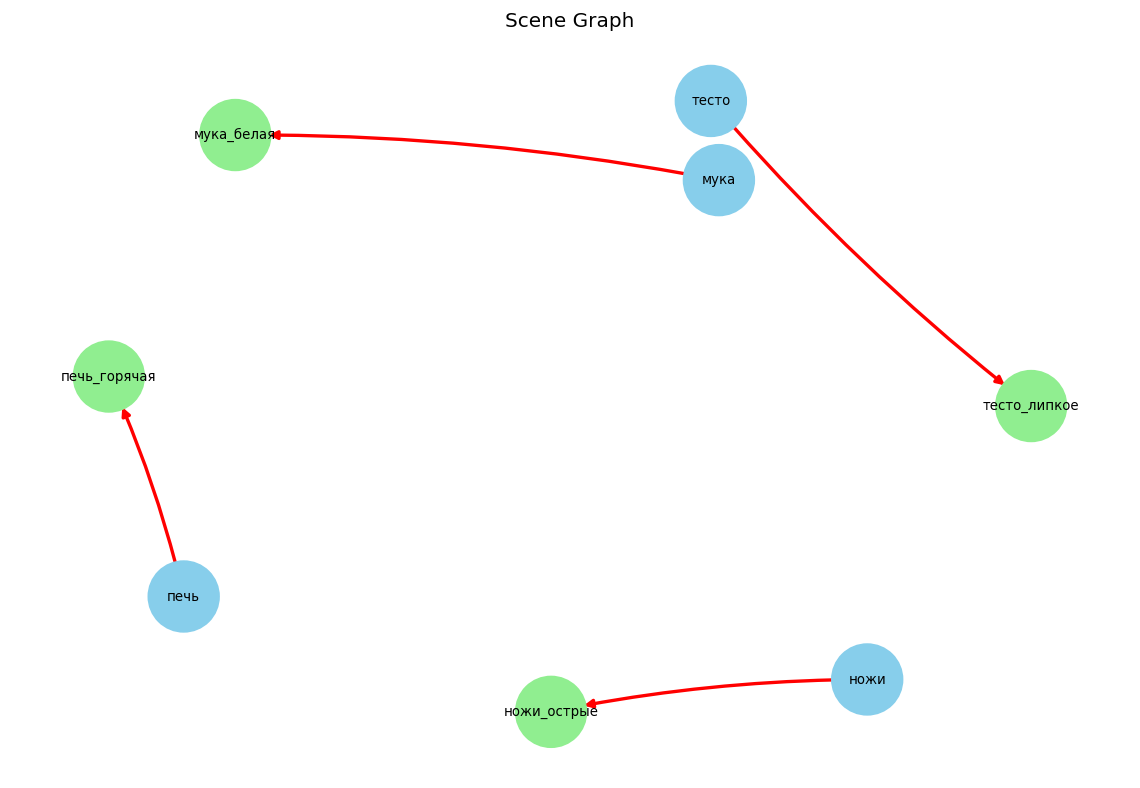

In [13]:
print(scene)
G = scene_to_graph(scene)
draw_scene_graph(G)

## Заворачивание json в сцену и валидация

Перемешивая порядок объектов и порядок признаков мы можем по одному и тому же json делать несколько 
различных генераций что ускорит создание датасета.

In [14]:
def shuffle_scene(scene: dict) -> dict:
    # Глубокая копия, чтобы не менять оригинал
    shuffled_scene = copy.deepcopy(scene)
    
    # Перемешиваем порядок объектов
    random.shuffle(shuffled_scene["objects"])

    # Перемешиваем признаки внутри каждого объекта
    for obj in shuffled_scene["objects"]:
        for obj_name, attributes in obj.items():
            random.shuffle(attributes)

    return shuffled_scene

def generate_description(scene):
    # генерируем сцену по заданному json
    scene_data = shuffle_scene(scene)
    #print(scene_data)
    prompt = f"""
Ты — помощник, создающий описание сцены строго по заданной структуре.

Соблюдай следующие правила:

1. Упомяни **все объекты**, указанные в структуре, ровно один раз, в порядке в каком они заданы. 
   Первый объект — это главный объект описания.
   Упоминание в пространственном отношении тоже считается упоминанием.
2. Перечисли **все признаки** каждого объекта (при наличии), ровно один раз для каждого признака объекта.
3. **Разрешено использовать только пространственные связи между заданными объектами**.
   - Например, если заданы объекты "кий" и "шар" то "кий лежит рядом с шаром» — корректно.
   - при описании пространственных связей запрещено использовать существительные и местоимения.
4. **Не добавляй новых объектов или признаков**, не используй синонимов или обобщений.
5. Не упоминай название локации.
6. Не используй вступительные фразы вроде "В сцене изображен..." — начни сразу с описания.
7. Букву "ё" заменяй на "е".

Объекты: упомяни **только один раз каждый объект**, и постарайся **естественным образом связать их между собой**, 
если это возможно.

Запрещено упоминать какие-либо объекты, которых нет в структуре сцены, даже если они подразумеваются 
контекстом (например: "стол", "пол", "поверхность", "платформа", "стена", "фон", "ткань", "сукно", "освещение" и т.д.).
Нельзя использовать эти слова даже как часть пространственного описания.

Если у объектов нет признаков, опиши их взаимное расположение только через прямую связь между ними. 
Например для описания  {{'location': 'бильярдная', 'objects': [{{'кий': []}}, {{'шар': []}}]}}:
"Шар лежит рядом с кием" — корректно. 'Шар лежит на столе, рядом с ним стоит кий.' - некорректно

        {json.dumps(scene_data, ensure_ascii=False, indent=2)}
   
"""

    #print(prompt)
    
    # deepseek-chat снова дает более адекватную выдачу по сравнению с gpt-4o-mini
    description = request_llm(
        prompt, API_KEY_DS, temperature=0.8, max_tokens=1000, 
        model='deepseek-chat', platform='deepseek', response_type="text")
    
    #description = request_llm(
    #    prompt, API_KEY, temperature=0.1, max_tokens=1000, 
    #    model='gpt-4o-mini', platform='openai', response_type="text")    

    #print(description)    
    return description

In [15]:
scene = {'location': 'больница', 'objects': [{'пациент': ['длинный', 'толстый']}, {'кушетка': ['грязный']}]}
#scene = {'location': 'больница', 'objects': [{'пациент': []}, {'кушетка': ['грязный','старый']}]}
#scene = {'location': 'больница', 'objects': [{'пациент': []}, {'кушетка': []}]}

In [16]:
generated_descriptions = []
for i in range(5):
    description = generate_description(scene)
    print(description)
    if description not in generated_descriptions:
        generated_descriptions.append(description)
        if len(generated_descriptions) >= MAX_DESCR_PER_SCENE:
            break
        

Грязная кушетка стоит рядом с толстым и длинным пациентом.


In [17]:
generated_descriptions

['Грязная кушетка стоит рядом с толстым и длинным пациентом.']

### Итоговая генерация датасета

In [18]:
# Определение, с какого батча начинать
existing = {f.name for f in DATASET_DIR.glob("dataset_batch_*.jsonl")}

start_batch = 0
while f"dataset_batch_{start_batch:03}.jsonl" in existing:
    start_batch += 1

#print(start_batch)    
    
# Основной цикл
for batch_num in range(start_batch, NUM_BATCHES):
    
    # после каждого батча собираем словари запретных слов
    
    property_counter = Counter()
    object_counter_by_location = defaultdict(Counter)

    # Обход всех jsonl-файлов
    for file in DATASET_DIR.glob("dataset_batch_*.jsonl"):
        with open(file, "r", encoding="utf-8") as f:
            for line in f:
                item = json.loads(line)
                scene = item["scene"]
                location = scene["location"]
                for obj in scene["objects"]:
                    for name, props in obj.items():
                        object_counter_by_location[location][name] += 1
                        property_counter.update(props)

    # Формируем exclude lists
    exclude_properties_list = [prop for prop, count in property_counter.items() if count > PROPERTY_THRESHOLD]

    exclude_objects_dict = {
        loc: [obj for obj, count in obj_counter.items() if count > OBJECT_THRESHOLD]
        for loc, obj_counter in object_counter_by_location.items()
    }
    #print(exclude_properties_list, exclude_objects_dict)
    
    
    results = []
    logging.info(f"Генерация батча #{batch_num}")

    with tqdm(total=BATCH_SIZE, desc=f"Батч {batch_num:03}", unit="сцена", ncols=90) as pbar:
        while len(results) < BATCH_SIZE:
            scene = generate_scene(exclude_objects_dict, exclude_properties_list)
            
            # по каждой сцене можем генерить несколько разных описаний
            generated_descriptions = []
            for i in range(5):
                description = generate_description(scene)
                if description not in generated_descriptions:
                    generated_descriptions.append(description)
                    results.append({"scene": scene, "description": description})
                    pbar.update(1)
                    if len(generated_descriptions) >= MAX_DESCR_PER_SCENE:
                        break            
                    
    # Сохраняем файл
    file_path = DATASET_DIR / f"dataset_batch_{batch_num:03}.jsonl"
    try:
        with open(file_path, "w", encoding="utf-8") as f:
            for item in results:
                f.write(json.dumps(item, ensure_ascii=False) + "\n")
        logging.info(f"Батч #{batch_num} сохранён в {file_path}\n")
    except Exception as e:
        logging.error(f"Ошибка записи батча #{batch_num}: {e}")

Батч 004: 100%|████████████████████████████████████████| 50/50 [20:16<00:00, 24.34s/сцена]


### Тестовое построение сцен на отдельном баче

In [ ]:
BATCH_NUM = "000"
with open(f"{DATASET_DIR}/dataset_batch_{BATCH_NUM}.jsonl", "r", encoding="utf-8") as f:
    for i, line in enumerate(f, 1):
        data = json.loads(line)
        print("\nsrc_text:", data.get("description", ""))
        scene = data.get("scene", "")
        print(scene)
        G = scene_to_graph(scene)
        draw_scene_graph(G)  